Bitcoin Prediction Using LGBM

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import your data
crypto_data = pd.read_csv('crypto_data.csv')

In [5]:
crypto_data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17 00:00:00+00:00,457.334015,457.334015,468.174011,452.421997,465.864014,2.105680e+07
1,2014-09-18 00:00:00+00:00,424.440002,424.440002,456.859985,413.104004,456.859985,3.448320e+07
2,2014-09-19 00:00:00+00:00,394.795990,394.795990,427.834991,384.532013,424.102997,3.791970e+07
3,2014-09-20 00:00:00+00:00,408.903992,408.903992,423.295990,389.882996,394.673004,3.686360e+07
4,2014-09-21 00:00:00+00:00,398.821014,398.821014,412.425995,393.181000,408.084991,2.658010e+07
...,...,...,...,...,...,...,...
3711,2024-11-14 00:00:00+00:00,87250.429690,87250.429690,91765.218750,86682.812500,90574.882810,8.761671e+10
3712,2024-11-15 00:00:00+00:00,91066.007810,91066.007810,91868.742190,87124.898440,87284.179690,7.824311e+10
3713,2024-11-16 00:00:00+00:00,90558.476560,90558.476560,91763.945310,90094.226560,91064.367190,4.433319e+10
3714,2024-11-17 00:00:00+00:00,89845.851560,89845.851560,91433.039060,88741.664060,90558.460940,4.635016e+10


In [7]:
crypto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3716 non-null   object 
 1   Adj Close  3716 non-null   float64
 2   Close      3716 non-null   float64
 3   High       3716 non-null   float64
 4   Low        3716 non-null   float64
 5   Open       3716 non-null   float64
 6   Volume     3716 non-null   float64
dtypes: float64(6), object(1)
memory usage: 203.3+ KB


In [9]:
# Convert 'Date' column to datetime
crypto_data['Date'] = pd.to_datetime(crypto_data['Date'])

In [11]:
# Remove timezone information from 'Date' column
crypto_data['Date'] = crypto_data['Date'].dt.tz_localize(None)

crypto_data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800.0
1,2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200.0
2,2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700.0
3,2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600.0
4,2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100.0


In [13]:
# Convert 'Date' column to datetime and set it as the index
crypto_data['Date'] = pd.to_datetime(crypto_data['Date'])
crypto_data.set_index('Date', inplace=True)


In [15]:
crypto_data

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,2.105680e+07
2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,3.448320e+07
2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,3.791970e+07
2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,3.686360e+07
2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,2.658010e+07
...,...,...,...,...,...,...
2024-11-14,87250.429690,87250.429690,91765.218750,86682.812500,90574.882810,8.761671e+10
2024-11-15,91066.007810,91066.007810,91868.742190,87124.898440,87284.179690,7.824311e+10
2024-11-16,90558.476560,90558.476560,91763.945310,90094.226560,91064.367190,4.433319e+10


In [17]:
# Drop 'Adj Close' since it is redundant
crypto_data = crypto_data.drop(['Adj Close'], axis=1)

In [19]:
# Feature engineering: Convert the Date column into day, month, and year
crypto_data['day'] = crypto_data.index.day
crypto_data['month'] = crypto_data.index.month
crypto_data['year'] = crypto_data.index.year
crypto_data

,Close,High,Low,Open,Volume,day,month,year
Date,,,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,2.105680e+07,17,9,2014
2014-09-18,424.440002,456.859985,413.104004,456.859985,3.448320e+07,18,9,2014
2014-09-19,394.795990,427.834991,384.532013,424.102997,3.791970e+07,19,9,2014
2014-09-20,408.903992,423.295990,389.882996,394.673004,3.686360e+07,20,9,2014
2014-09-21,398.821014,412.425995,393.181000,408.084991,2.658010e+07,21,9,2014
...,...,...,...,...,...,...,...,...
2024-11-14,87250.429690,91765.218750,86682.812500,90574.882810,8.761671e+10,14,11,2024
2024-11-15,91066.007810,91868.742190,87124.898440,87284.179690,7.824311e+10,15,11,2024
2024-11-16,90558.476560,91763.945310,90094.226560,91064.367190,4.433319e+10,16,11,2024


In [21]:
# Check for missing values
print(crypto_data.isnull().sum())

Close     0
High      0
Low       0
Open      0
Volume    0
day       0
month     0
year      0
dtype: int64


Cool!, the data has no missing values

In [26]:
# Scaling the features (especially 'Volume', 'Open', 'High', 'Low', and 'Close')
scaler = StandardScaler()
crypto_data[['Close', 'High', 'Low', 'Open', 'Volume']] = scaler.fit_transform(crypto_data[['Close', 'High', 'Low', 'Open', 'Volume']])


In [28]:
# Split the data into features (X) and target (y)
X = crypto_data.drop('Close', axis=1)  # Using features except 'Close' as target
y = crypto_data['Close']  # The target is 'Close' price

In [30]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (2972, 7)
X_test shape: (744, 7)


**Model Training**

In [43]:
# Create the LGBM dataset

# Initialize and train the LGBM model
lgbm_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31)
lgbm_model.fit(X_train, y_train)

# Model evaluation
from sklearn.metrics import mean_squared_error, r2_score
y_pred = lgbm_model.predict(X_test)

# Calculate RMSE and R2 score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print RMSE and R2 Score
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 2972, number of used features: 7
[LightGBM] [Info] Start training from score 0.010046
RMSE: 0.029447613356843254
R2 Score: 0.9991223029699879


Model Evaluation

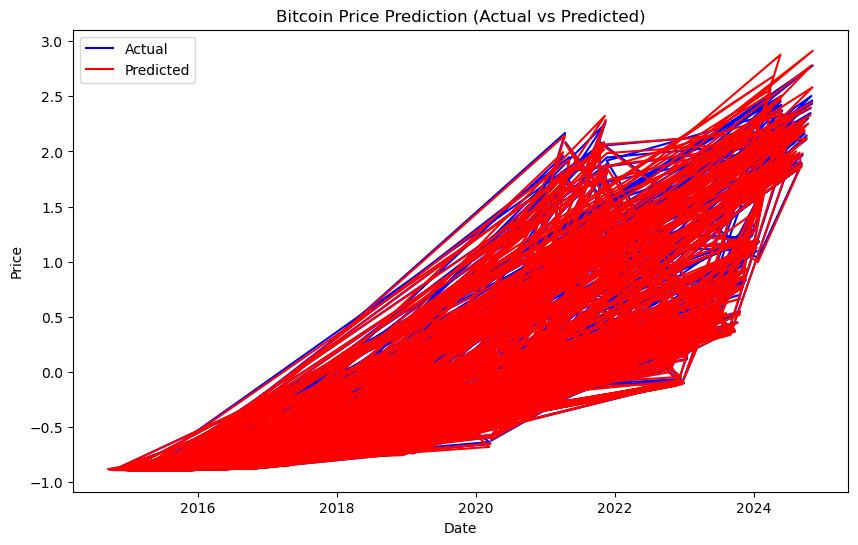

In [51]:
# Visualization: Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, color='blue', label='Actual')
plt.plot(y_test.index, y_pred, color='red', label='Predicted')
plt.title('Bitcoin Price Prediction (Actual vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [78]:
X_train 

,High,Low,Open,Volume,day,month,year
Date,,,,,,,
2020-02-04,-0.463992,-0.453473,-0.455697,0.606014,4,2,2020
2016-05-05,-0.886608,-0.885061,-0.886033,-0.918016,5,5,2016
2019-05-08,-0.622961,-0.618705,-0.623206,-0.138189,8,5,2019
2022-09-15,0.058733,0.070588,0.076957,0.937747,15,9,2022
2015-07-10,-0.893931,-0.893880,-0.894670,-0.915465,10,7,2015
...,...,...,...,...,...,...,...
2017-10-21,-0.613212,-0.610222,-0.616040,-0.807878,21,10,2017
2018-04-03,-0.549646,-0.555075,-0.562262,-0.639729,3,4,2018
2017-01-24,-0.863978,-0.862832,-0.863462,-0.914905,24,1,2017


Saving my model

In [102]:
booster = lgbm_model.booster_  # Access the Booster object
booster.save_model('lgbm_bitcoin_price_model.txt')

Streamlit deployment

In [106]:
# Create the file Expresso_Churn_Prediction_Streamlit_App.py in write mode
with open("Bitcoin_price_prediction_app.py", "w") as file:
    # Writing the Streamlit code into the file
    file.write("""
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

st.title("Bitcoin Price Prediction using LGBM")

# Load dataset
crypto_data = pd.read_csv('Documents/Data Science/Project/crypto_data_final.csv')

# Feature engineering
crypto_data['Date'] = pd.to_datetime(crypto_data['Date'])
crypto_data.set_index('Date', inplace=True)
crypto_data['day'] = crypto_data.index.day
crypto_data['month'] = crypto_data.index.month
crypto_data['year'] = crypto_data.index.year

# Scale features
scaler = StandardScaler()
crypto_data[['Close', 'High', 'Low', 'Open', 'Volume']] = scaler.fit_transform(crypto_data[['Close', 'High', 'Low', 'Open', 'Volume']])

# Prepare training data
X = crypto_data.drop('Close', axis=1)
y = crypto_data['Close']

# Load the trained LGBM model
lgbm_model = lgb.Booster(model_file='Documents/Data Science/Project/lgbm_bitcoin_price_model.txt')

st.write("Predict the Bitcoin Price")
date_input = st.date_input("Select a date", min_value=crypto_data.index.min(), max_value=crypto_data.index.max())
selected_date = pd.to_datetime(date_input)

# Get input data for prediction
input_data = crypto_data.loc[selected_date]

# Align features to match training
input_data = input_data[X.columns]

# Predict
prediction = lgbm_model.predict(input_data.values.reshape(1, -1))
st.write(f"Predicted Bitcoin Price for {selected_date.strftime('%Y-%m-%d')}: ${prediction[0]:.2f}")
""")